## Generating a tree graph state

In this notebook we generate tree graph states with the sequential emission protocol

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.sparse as sps

import cirq
from qutip import *

import qutrit_utils
import graph_state_gen_circuits as gsg

In [2]:
### system parameters
nbranches = [1,2,3]

waittimes = [0.125, 0.2, 0.125, 0.125, 0.075, 0.205, 0.275] # T_h, T_cz, T_pief, T_cnot, T_wait, T_swap1, T_swap2
coherence_times1 = [27, 22, 16, 12]
coherence_times2 = [22, 23, 4, 6]

nparams = [0.0, 0.02, 0.01, 0.0]

In [3]:
##-- initialize the simulators
simulator = cirq.Simulator()
dsim = cirq.DensityMatrixSimulator()

In [4]:
#gsg.leak_tree_graph_state(2, 0.0, 0.0, 0.0)

In [5]:
#gsg.noisy_tree_graph_state(2, waittimes, coherence_times1, coherence_times2, nparams)

## Generating the states

In [6]:
%%time
### the ideal states
noiseless_states = []

for qu in nbranches:
    nqubits = 3*qu + 1
    
    #- run the circuit
    ideal_run = simulator.simulate(gsg.leak_tree_graph_state(qu,0,0,0))
    
    #- ideal state in csr form
    ideal_rho = sps.csr_matrix(np.outer(np.conj(ideal_run.final_state_vector), ideal_run.final_state_vector))
    
    #- ideal state as qutip object
    irho = Qobj(ideal_rho, dims = [[3,3] + [2]*nqubits, [3,3] + [2]*nqubits])
    
    #- reduced state of the qubit register (trace out the storages)
    irho_qubits = ptrace(irho, list(range(2, nqubits+2)))
    
    noiseless_states.append(irho_qubits)
    
    print("Computation for %d branches, done -->>" % qu)
#

Computation for 1 branches, done -->>
Computation for 2 branches, done -->>
Computation for 3 branches, done -->>
CPU times: user 1.16 s, sys: 389 ms, total: 1.55 s
Wall time: 1.9 s


In [7]:
%%time
### the decoherence limited states
deco_states = []

for qu in nbranches:
    nqubits = 3*qu + 1
    #- run the circuit
    deco_run = dsim.simulate(gsg.noisy_tree_graph_state(qu, waittimes, coherence_times1, coherence_times2, [0,0,0,0]))
    
    #- deco state in csr form
    deco_rho = sps.csr_matrix(deco_run.final_density_matrix)
    
    #- ideal state as qutip object
    drho = Qobj(deco_rho, dims = [[3,3] + [2]*nqubits, [3,3] + [2]*nqubits])
    
    #- reduced state of the qubit register (trace out the storages)
    drho_qubits = ptrace(drho, list(range(2, nqubits+2)))
    
    deco_states.append(drho_qubits)
    print("Computation for %d branches, done -->>" % qu)
#

Computation for 1 branches, done -->>
Computation for 2 branches, done -->>
Computation for 3 branches, done -->>
CPU times: user 36.9 s, sys: 21.5 s, total: 58.4 s
Wall time: 1min 10s


In [8]:
%%time
### the noisy states
noisy_states = []

for qu in nbranches:
    nqubits = 3*qu + 1
    #- run the circuit
    noisy_run = dsim.simulate(gsg.noisy_tree_graph_state(qu, waittimes, coherence_times1, coherence_times2, nparams))
    
    #- deco state in csr form
    noisy_rho = sps.csr_matrix(noisy_run.final_density_matrix)
    
    #- ideal state as qutip object
    nrho = Qobj(noisy_rho, dims = [[3,3] + [2]*nqubits, [3,3] + [2]*nqubits])
    
    #- reduced state of the qubit register (trace out the storages)
    nrho_qubits = ptrace(nrho, list(range(2, nqubits+2)))
    
    noisy_states.append(nrho_qubits)
    
    print("Computation for %d branches, done -->>" % qu)
#

Computation for 1 branches, done -->>
Computation for 2 branches, done -->>
Computation for 3 branches, done -->>
CPU times: user 36.9 s, sys: 22.2 s, total: 59.1 s
Wall time: 1min 1s


### Fidelities

In [9]:
fides_deco = []
fides_noisy = []

for qq in range(len(nbranches)):
    fdeco = fidelity(deco_states[qq], noiseless_states[qq])**2
    ndeco = fidelity(noisy_states[qq], noiseless_states[qq])**2
    
    fides_deco.append(fdeco)
    fides_noisy.append(ndeco)
    
    print(nbranches[qq], fdeco, ndeco)
#

1 0.9148478016894261 0.8455664782977766
2 0.8368955785843096 0.7292191105066901
3 0.7659605366792755 0.6304502618122495


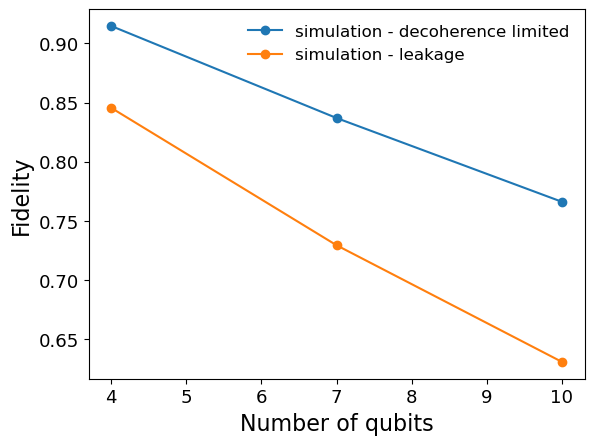

In [13]:
plt.plot(3*np.array(nbranches)+1, fides_deco, "o-", label = "simulation - decoherence limited")
plt.plot(3*np.array(nbranches)+1, fides_noisy, "o-", label = "simulation - leakage")

plt.legend(loc = "upper right", fontsize = 12, frameon = False)
plt.xlabel("Number of qubits", fontsize = 16)
plt.ylabel("Fidelity", fontsize = 16)
plt.tick_params(axis = "both", labelsize = 13)
plt.show()

## Exporting the states

In [ ]:
### path
#patho = "/Users/munm2002/Documents/projects/graph_states_for_ent_witness/data_states/tree_graph_state/"

In [ ]:
# ### save the states
# for ii in range(len(nbranches)):
#     nqubits = 3*nbranches[ii] + 1

#     qsave(noisy_states[ii], patho+"tree_graph_state_%dbranches_%dqubits.qu" % (nbranches[ii], nqubits))

#     print("Size %d, completed -->>" % (nbranches[ii]))
# #

In [ ]:
# ### checking the stabilizers
# #- signle site operators
# sx = sigmax()
# sz = sigmaz()
# ide = identity(dims = [2])

# #- stabilizer generators (for tree graph with two branches)
# S1 = tensor([sx, ide, sz, ide, ide, sz, ide])
# S2 = tensor([ide, sx, sz, ide, ide, ide, ide])
# S3 = tensor([sz, sz, sx, sz, ide, ide, ide])
# S4 = tensor([ide, ide, sz, sx, ide, ide, ide])
# S5 = tensor([ide, ide, ide, ide, sx, sz, ide])
# S6 = tensor([sz, ide, ide, ide, sz, sx, sz])
# S7 = tensor([ide, ide, ide, ide, ide, sz, sx])

# #- compute expectations
# e1 = expect(S1, noiseless_states[1])
# e2 = expect(S2, noiseless_states[1])
# e3 = expect(S3, noiseless_states[1])
# e4 = expect(S5, noiseless_states[1])
# e5 = expect(S5, noiseless_states[1])
# e6 = expect(S6, noiseless_states[1])
# e7 = expect(S7, noiseless_states[1])

# print(e1)
# print(e2)
# print(e3)
# print(e4)
# print(e5)
# print(e6)
# print(e7)